In [1]:
import os
import torch
import timeit
import random
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn import decomposition
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

durs = []
lens = []

for file in os.listdir('.'):
    dur = librosa.get_duration(filename=file)
    audioinput, sr = librosa.load(file, sr=16000)
    durs.append(dur)
    lens.append(len(audioinput))

print(np.mean(np.array(durs)) + np.std(np.array(durs))) # ave duration + std deviation
print(np.mean(np.array(lens)) + np.std(np.array(lens))) # ave duration + std deviation

3.806839123563467
60909.42597701548


In [44]:
path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

hct_A = np.array([])
hct_E = np.array([])
hct_F = np.array([])
hct_L = np.array([])
hct_N = np.array([])
hct_T = np.array([])
hct_W = np.array([])

for file in os.listdir('.'):
    hct = np.array([])
    audioinput, sr = librosa.load(file, sr=16000, duration=3.8068)
    audioinput = librosa.util.fix_length(audioinput, size=60800, mode="edge") #pad to same length
    
#     spectral features
    mfcc = librosa.feature.mfcc(y=audioinput, sr=sr, n_fft=800, hop_length=400, n_mfcc=40)
    mfcc_frame = np.mean(mfcc.T, axis=0) #frame level
    mfcc_phoneme = []
    for i in range(0,len(mfcc_frame)-3,2):
        mfcc_phoneme.append((mfcc_frame[i]+mfcc_frame[i+1]+mfcc_frame[i+2])/3) #phoneme level
    mfcc_word=[]
    for i in range(0, len(mfcc_phoneme)-5,4):
        mfcc_word.append((mfcc_phoneme[i]+mfcc_phoneme[i+1]+mfcc_phoneme[i+4])/5) #word level
    mfcc_utter=[]
    for i in range(0, len(mfcc_word)-10,9):
        mfcc_utter.append((mfcc_word[i]+mfcc_word[i+1]+mfcc_word[i+9])/5) #utterance level
    
    kur_c = kurtosis(mfcc_frame)
    ske_c = skew(mfcc_frame)
    max_c = np.amax(np.array(mfcc_frame), axis=0)
    min_c = np.amin(np.array(mfcc_frame), axis=0)
    ave_c = np.mean(np.array(mfcc_frame), axis=0)
    rag_c = max_c-min_c

    for i in (kur_c, ske_c, max_c, min_c, ave_c, rag_c):
        mfcc_utter.append(i) #utterance level

#     mel = librosa.feature.melspectrogram(y=audioinput, sr=sr, n_fft=800, hop_length=400)
#     mel_del = librosa.feature.delta(mel, order=1)
#     mel_del2 = librosa.feature.delta(mel, order=2)
#     mels = np.vstack((mel, mel_del, mel_del2))
#     mels_frame = np.mean(mels.T, axis=0)
#     mels_phoneme = []
#     for i in range(0,len(mels_frame)-3,2):
#         mels_phoneme.append((mels_frame[i]+mels_frame[i+1]+mels_frame[i+2])/3) #phoneme level
#     mels_word=[]
#     for i in range(0, len(mels_phoneme)-5,4):
#         mels_word.append((mels_phoneme[i]+mels_phoneme[i+1]+mels_phoneme[i+4])/5) #word level
#     mels_utter=[]
#     for i in range(0, len(mels_word)-10,9):
#         mels_utter.append((mels_word[i]+mels_word[i+1]+mels_word[i+9])/5) #utterance level
    
#     kur_m = kurtosis(mels_frame)
#     ske_m = skew(mels_frame)
#     max_m = np.amax(np.array(mels_frame), axis=0)
#     min_m = np.amin(np.array(mels_frame), axis=0)
#     ave_m = np.mean(np.array(mels_frame), axis=0)
#     rag_m = max_m-min_m
            
#     for i in (kur_m, ske_m, max_m, min_m, ave_m, rag_m):
#         mels_utter.append(i) #utterance level
                
#     prosodic features
#     eng_frame = librosa.feature.rms(y=audioinput, frame_length=800, hop_length=400)
#     f0_frame = librosa.yin(audioinput, frame_length=800, hop_length=400, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

#     eng_phoneme = []
#     for i in range(0,len(eng_frame)-3,2):
#         eng_phoneme.append((eng_frame[i]+eng_frame[i+1]+eng_frame[i+2])/3) #phoneme level
#     eng_word=[]
#     for i in range(0, len(eng_phoneme)-5,4):
#         eng_word.append((eng_phoneme[i]+eng_phoneme[i+1]+eng_phoneme[i+4])/5) #word level
#     eng_utter=[]
#     for i in range(0, len(eng_word)-10,9):
#         eng_utter.append((eng_word[i]+eng_word[i+1]+eng_word[i+9])/5) #utterance level
        
#     f0_phoneme = []
#     for i in range(0,len(f0_frame)-3,2):
#         f0_phoneme.append((f0_frame[i]+f0_frame[i+1]+f0_frame[i+2])/3) #phoneme level
#     f0_word=[]
#     for i in range(0, len(f0_phoneme)-5,4):
#         f0_word.append((f0_phoneme[i]+f0_phoneme[i+1]+f0_phoneme[i+4])/5) #word level
#     f0_utter=[]
#     for i in range(0, len(f0_word)-10,9):
#         f0_utter.append((f0_word[i]+f0_word[i+1]+f0_word[i+9])/5) #utterance level
    
#     kur_e = kurtosis(eng_frame)
#     ske_e = skew(eng_frame)
#     max_e = np.amax(np.array(eng_frame), axis=0)
#     min_e = np.amin(np.array(eng_frame), axis=0)
#     ave_e = np.mean(np.array(eng_frame), axis=0)
#     rag_e = max_e-min_e
    
#     kur_f = kurtosis(f0_frame)
#     ske_f = skew(f0_frame)
#     max_f = np.amax(np.array(f0_frame), axis=0)
#     min_f = np.amin(np.array(f0_frame), axis=0)
#     ave_f = np.mean(np.array(f0_frame), axis=0)
#     rag_f = max_f-min_f

#     for i in (kur_e, ske_e, max_e, min_e, ave_e, rag_e):
#         eng_utter.append(i)
#     for i in (kur_f, ske_f, max_f, min_f, ave_f, rag_f):
#         f0_utter.append(i)
    
    hct = np.array(mfcc_word)
    
    #separate accroindg to emotions
    if file[5] == 'A':
        hct_A = np.append(hct_A, hct)
        hct_A = np.reshape(hct_A, (-1, hct.size))
    elif file[5] == 'E':
        hct_E = np.append(hct_E, hct)
        hct_E = np.reshape(hct_E, (-1, hct.size)) 
    elif file[5] == 'F':
        hct_F = np.append(hct_F, hct)
        hct_F = np.reshape(hct_F, (-1, hct.size))
    elif file[5] == 'L':
        hct_L = np.append(hct_L, hct)
        hct_L = np.reshape(hct_L, (-1, hct.size))
    elif file[5] == 'N':
        hct_N = np.append(hct_N, hct)
        hct_N = np.reshape(hct_N, (-1, hct.size))
    elif file[5] == 'T':
        hct_T = np.append(hct_T, hct)
        hct_T = np.reshape(hct_T, (-1, hct.size))
    elif file[5] == 'W':
        hct_W = np.append(hct_W, hct)
        hct_W = np.reshape(hct_W, (-1, hct.size))

print('finished')

finished


In [45]:
hct_feats = np.vstack((hct_A, hct_E, hct_F, hct_L, hct_N, hct_T, hct_W))
labels = [0] * 69 + [1] * 46 + [2] * 71 + [3] * 81 + [4] * 79 + [5] * 62 + [6] * 127

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

for file in os.listdir('.'):
    audioinput, sr = librosa.load(file, sr=16000, duration=3.8)
    audioinput = librosa.util.fix_length(audioinput, size=60800, mode="edge") #pad to same length    
    
    #w2v features
    input_values = processor(audioinput, sampling_rate=16000, return_tensors="pt").input_values.to(DEVICE)
    w2v_feats = w2v_model(input_values, output_hidden_states=True).hidden_states
    w2v_feats_0 = w2v_feats[0].detach()[0].mean(dim=0)
    w2v_feats_1 = w2v_feats[1].detach()[0].mean(dim=0)
    w2v_feats_7 = w2v_feats[7].detach()[0].mean(dim=0)
    w2v_feats_11 = w2v_feats[11].detach()[0].mean(dim=0)
    w2v_feats_12 = w2v_feats[12].detach()[0].mean(dim=0)
    
    #separate accroindg to emotions
#     if file[5] == 'A':

#     elif file[5] == 'E':

#     elif file[5] == 'F':

#     elif file[5] == 'L':

#     elif file[5] == 'N':
      
#     elif file[5] == 'T':

#     elif file[5] == 'W':


print('finished')

finished


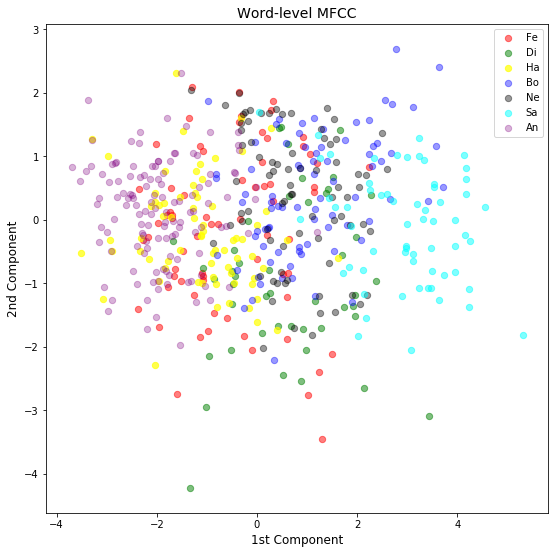

In [46]:
#plot 2d distribution

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

X = hct_feats
Y = labels

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# pca = PCA(n_components=2)
# pca.fit(X_scaled, Y)
# X_new = pca.transform(X_scaled)

lda = LDA(n_components=2)
lda.fit(X_scaled, Y)
X_new = lda.transform(X_scaled)

ex_variance=np.var(X_new,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio

Xax = X_new[:,0]
Yax = X_new[:,1]

cdict = {0:'red',1:'green',2:'yellow',3:'blue',4:'black',5:'cyan',6:'purple'}
labl = {0:'Fe',1:'Di',2:'Ha',3:'Bo',4:'Ne',5:'Sa',6:'An'}
marker = {0:'o',1:'o',2:'o',3:'o',4:'o',5:'o',6:'o'}
alpha = {0:.5,1:.5,2:.7,3:.4,4:.4,5:.5,6:.3}

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)

fig.patch.set_facecolor('white')
for l in np.unique(Y):
    ix=np.where(Y==l)
    ax.scatter(Xax[ix], Yax[ix], c=cdict[l], s=40, label=labl[l], marker=marker[l], alpha=alpha[l])

ax.set_xlabel('1st Component', fontsize=12)
ax.set_ylabel('2nd Component', fontsize=12)
ax.set_title('Word-level MFCC', fontsize=14)

ax.legend()
plt.show()

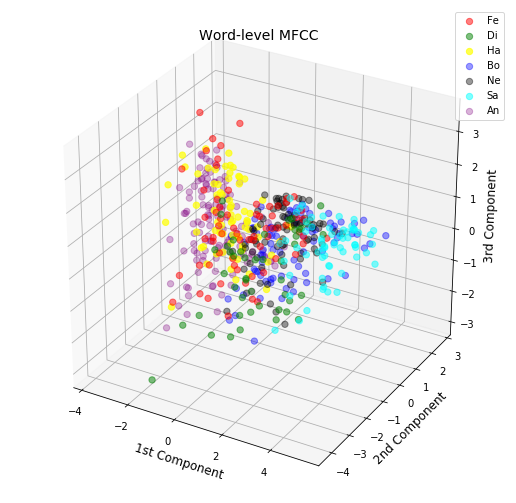

In [47]:
#plot 3d distribution

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

X = hct_feats
Y = labels

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# pca = PCA(n_components=3)
# pca.fit(X_scaled) 
# X_pca = pca.transform(X_scaled)

lda = LDA(n_components=3)
lda.fit(X_scaled, Y)
X_new = lda.transform(X_scaled)

ex_variance=np.var(X_new,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio

Xax = X_new[:,0]
Yax = X_new[:,1]
Zax = X_new[:,2]

cdict = {0:'red',1:'green',2:'yellow',3:'blue',4:'black',5:'cyan',6:'purple'}
labl = {0:'Fe',1:'Di',2:'Ha',3:'Bo',4:'Ne',5:'Sa',6:'An'}
marker = {0:'o',1:'o',2:'o',3:'o',4:'o',5:'o',6:'o'}
alpha = {0:.5,1:.5,2:.7,3:.4,4:.4,5:.5,6:.3}

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(Y):
    ix=np.where(Y==l)
    ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40, label=labl[l], marker=marker[l], alpha=alpha[l])

ax.set_xlabel("1st Component", fontsize=12)
ax.set_ylabel("2nd Component", fontsize=12)
ax.set_zlabel("3rd Component", fontsize=12)
ax.set_title('Word-level MFCC', fontsize=14)

ax.legend()
plt.show()

In [6]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader

A = X_scaled[0:69]
yA = [1]*69
E = X_scaled[69:115]
yE = [1]*46
F = X_scaled[115:186]
yF = [1]*71
L = X_scaled[186:267]
yL = [1]*81
N = X_scaled[267:346]
yN = [1]*79
T = X_scaled[346:408]
yT = [1]*62
W = X_scaled[408:535]
yW = [1]*127

A_train = A[:int(69*0.7)]
A_test = A[int(69*0.7):]
E_train = E[:int(46*0.7)]
E_test = E[int(46*0.7):]
F_train = F[:int(71*0.7)]
F_test = F[int(71*0.7):]
L_train = L[:int(81*0.7)]
L_test = L[int(81*0.7):]
N_train = N[:int(79*0.7)]
N_test = N[int(79*0.7):]
T_train = T[:int(62*0.7)]
T_test = T[int(62*0.7):]
W_train = W[:int(127*0.7)]
W_test = W[int(127*0.7):]

In [7]:
#Quantitative analysis

#A vs other
x_train = np.vstack((A_train,E_train,F_train,L_train,N_train,T_train,W_train))
x_test = np.vstack((A_test,E_test,F_test,L_test,N_test,T_test,W_test))
y_train = yA[:int(69*0.7)] + [0]*(len(x_train)-len(yA[:int(69*0.7)]))
y_test = yA[int(69*0.7):] + [0]*(len(x_test)-len(yA[int(69*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Fear_Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Fear_Precision:",metrics.precision_score(y_test, y_pred))
print("Fear_Recall:",metrics.recall_score(y_test, y_pred))

#E vs other
x_train = np.vstack((E_train,A_train,F_train,L_train,N_train,T_train,W_train))
x_test = np.vstack((E_test,A_test,F_test,L_test,N_test,T_test,W_test))
y_train = yE[:int(46*0.7)] + [0]*(len(x_train)-len(yE[:int(46*0.7)]))
y_test = yE[int(46*0.7):] + [0]*(len(x_test)-len(yE[int(46*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Disg_Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Disg_Precision:",metrics.precision_score(y_test, y_pred))
print("Disg_Recall:",metrics.recall_score(y_test, y_pred))

#F vs other
x_train = np.vstack((F_train,A_train,E_train,L_train,N_train,T_train,W_train))
x_test = np.vstack((F_test,A_test,E_test,L_test,N_test,T_test,W_test))
y_train = yF[:int(71*0.7)] + [0]*(len(x_train)-len(yF[:int(71*0.7)]))
y_test = yF[int(71*0.7):] + [0]*(len(x_test)-len(yF[int(71*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Happ_Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Happ_Precision:",metrics.precision_score(y_test, y_pred))
print("Happ_Recall:",metrics.recall_score(y_test, y_pred))

#L vs other
x_train = np.vstack((L_train,A_train,E_train,F_train,N_train,T_train,W_train))
x_test = np.vstack((L_test,A_test,E_test,F_test,N_test,T_test,W_test))
y_train = yL[:int(81*0.7)] + [0]*(len(x_train)-len(yL[:int(81*0.7)]))
y_test = yL[int(81*0.7):] + [0]*(len(x_test)-len(yL[int(81*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Bord_Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Bord_Precision:",metrics.precision_score(y_test, y_pred))
print("Bord_Recall:",metrics.recall_score(y_test, y_pred))

#N vs other
x_train = np.vstack((N_train,A_train,E_train,F_train,L_train,T_train,W_train))
x_test = np.vstack((N_test,A_test,E_test,F_test,L_test,T_test,W_test))
y_train = yN[:int(79*0.7)] + [0]*(len(x_train)-len(yN[:int(79*0.7)]))
y_test = yN[int(79*0.7):] + [0]*(len(x_test)-len(yN[int(79*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Neut_Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Neut_Precision:",metrics.precision_score(y_test, y_pred))
print("Neut_Recall:",metrics.recall_score(y_test, y_pred))

#T vs other
x_train = np.vstack((T_train,A_train,E_train,F_train,L_train,N_train,W_train))
x_test = np.vstack((T_test,A_test,E_test,F_test,L_test,N_test,W_test))
y_train = yT[:int(62*0.7)] + [0]*(len(x_train)-len(yT[:int(62*0.7)]))
y_test = yT[int(62*0.7):] + [0]*(len(x_test)-len(yT[int(62*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Sadn_Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Sadn_Precision:",metrics.precision_score(y_test, y_pred))
print("Sadn_Recall:",metrics.recall_score(y_test, y_pred))

#W vs other
x_train = np.vstack((W_train,A_train,E_train,F_train,L_train,N_train,T_train))
x_test = np.vstack((W_test,A_test,E_test,F_test,L_test,N_test,T_test))
y_train = yW[:int(127*0.7)] + [0]*(len(x_train)-len(yW[:int(127*0.7)]))
y_test = yW[int(127*0.7):] + [0]*(len(x_test)-len(yW[int(127*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Ange_Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Ange_Precision:",metrics.precision_score(y_test, y_pred))
print("Ange_Recall:",metrics.recall_score(y_test, y_pred))

Fear_Accuracy: 0.8719512195121951
Fear_Precision: 0.0
Fear_Recall: 0.0
Disg_Accuracy: 0.9146341463414634
Disg_Precision: 0.0
Disg_Recall: 0.0
Happ_Accuracy: 0.8658536585365854
Happ_Precision: 0.0
Happ_Recall: 0.0
Bord_Accuracy: 0.8475609756097561
Bord_Precision: 0.0
Bord_Recall: 0.0
Neut_Accuracy: 0.8536585365853658
Neut_Precision: 0.0
Neut_Recall: 0.0
Sadn_Accuracy: 0.8902439024390244
Sadn_Precision: 1.0
Sadn_Recall: 0.05263157894736842


/afs/inf.ed.ac.uk/user/s20/s2057508/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/afs/inf.ed.ac.uk/user/s20/s2057508/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/afs/inf.ed.ac.uk/user/s20/s2057508/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/afs/inf.ed.ac.uk/user/s20/s205750

Ange_Accuracy: 0.7560975609756098
Ange_Precision: 0.0
Ange_Recall: 0.0


In [30]:
import h5py
hf = h5py.File('/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin//feats/mfcc.h5', 'w')
hf.create_dataset('fear', data=hct_A)
hf.create_dataset('disg', data=hct_E)
hf.create_dataset('happ', data=hct_F)
hf.create_dataset('bord', data=hct_L)
hf.create_dataset('neut', data=hct_N)
hf.create_dataset('sadn', data=hct_T)
hf.create_dataset('ange', data=hct_W)
hf.close()